In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [10]:
# Import libraries
import pandas as pd

# Load pre-saved training and testing data
X_train = pd.read_csv('/content/data/processed/X_train.csv')
X_test = pd.read_csv('/content/data/processed/X_test.csv')
y_train = pd.read_csv('/content/data/processed/y_train.csv')
y_test = pd.read_csv('/content/data/processed/y_test.csv')

# Check their shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Inspect a few rows to verify
display(X_train.head())
display(y_train.head())


X_train shape: (3978, 21)
X_test shape: (426, 21)
y_train shape: (3978, 1)
y_test shape: (426, 1)


,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,-1.032333,-0.834435,-0.206244,0.896032,0.047600,-0.059461,2.986443,-1.195728,3.331247,-0.535843,...,1.939469,-1.474154,1.782380,1.320689,1.032381,-0.687493,-1.887059,-1.726861,3.316840,-0.526713
1,0.192158,-0.575829,-0.164756,-1.484534,-0.630753,-0.059461,-0.272713,0.652431,-0.828669,0.277039,...,0.626853,-0.794055,0.055794,0.308022,-0.470307,0.101947,0.353185,0.209634,-0.575860,1.113126
2,0.294199,-0.834435,-0.206244,0.896032,0.725953,-0.059461,-0.272713,-0.675933,-0.266518,-0.535843,...,0.395215,-0.828060,-0.501169,-0.367089,-0.470307,-0.080231,-0.094864,-0.067008,-0.169665,1.113126
3,1.722772,-0.834435,-0.206244,-1.144453,-0.630753,-0.059461,-0.272713,1.980795,-1.053530,0.385423,...,-0.685763,1.246243,0.557061,-0.704645,-0.470307,0.891388,0.993254,0.901239,-0.609710,-0.526713
4,0.600322,0.717204,-0.164756,1.916275,1.404306,-0.059461,-0.272713,0.421411,0.295633,-0.535843,...,0.652590,-0.590025,0.445668,-0.029534,1.032381,1.437923,0.289178,0.486276,1.996707,1.113126


,NSP
0,3.0
1,1.0
2,1.0
3,3.0
4,1.0


# Neural Networks

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
mlp = MLPClassifier(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train.values.ravel())

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}
Best CV score: 0.9839139091684839


In [11]:
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
y_proba = best_mlp.predict_proba(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

print("Neural Network Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Neural Network Performance:
Accuracy: 0.9202
Precision: 0.9216
Recall: 0.9202
F1-score: 0.9208
ROC AUC: 0.9807

Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       332
         2.0       0.72      0.75      0.73        59
         3.0       0.86      0.89      0.87        35

    accuracy                           0.92       426
   macro avg       0.85      0.86      0.86       426
weighted avg       0.92      0.92      0.92       426



  0%|          | 0/50 [00:00<?, ?it/s]

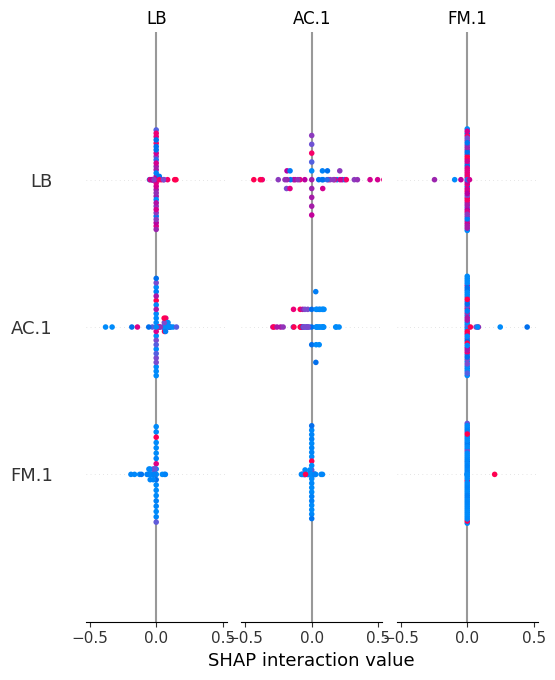

In [12]:
import shap

explainer = shap.KernelExplainer(best_mlp.predict_proba, X_train_scaled[:100])
shap_values = explainer.shap_values(X_test_scaled[:50])

shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X_train.columns)
